In [320]:
import numpy as np
from sympy import symbols, init_printing, Eq, solve, solve_rational_inequalities, simplify, plot_implicit
import decimal
init_printing()

https://www.best-microcontroller-projects.com/tp4056-page2.html

TP4056 will stop charging if voltage on TEMP pin is above 80% or below 45% of VIN.

We want to target charging within 5C and 45C
> Edit: looks like a solution doesn't exist for this range, let's use 2C to 48C

Let's first figure out the resistance of the battery NTC at these temperatures.

Values taken from https://github.com/Gigahawk/ipod_photo_battery_thermistor_analysis

In [309]:
BETA = 3084.4061812972204
R_inf = 0.3100372265380624
def curve(T_K):
    # Return resistance at given temperature (Kelvin)
    return R_inf*np.exp(BETA/T_K)
temps_C = np.array([2, 48])
temps_K = temps_C + 273.15
R_charge = curve(temps_K)
R_charge

array([22898.92119572,  4597.14678329])

Looking at the reference application diagram:
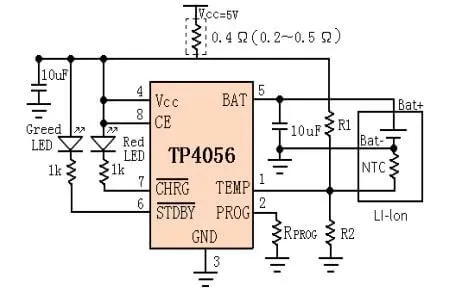

We see that the the TEMP pin is connected to a resistor divider with R1 at the top and R2//NTC at the bottom.

> Note: because we have attached external protection circuitry to the battery, the NTC is not truly connected to ground as it is in the diagram above, the resistance will actually change with the R_dsON of the battery protection MOSFETs, however this is assumed to be negligible

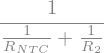

In [310]:
# Setting up initial symbols and parallel operator
R_1, R_2, R_NTC = symbols("R_1 R_2 R_NTC", positive=True)
def parallel(*args):
    inv = sum([1/a for a in args])
    return 1/inv
R_p = parallel(R_2, R_NTC)
R_p

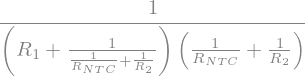

In [311]:
# Voltage at TEMP
V_T = R_p/(R_1 + R_p)
V_T

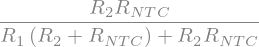

In [312]:
V_T = simplify(V_T)
V_T

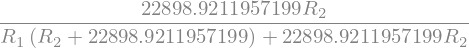

In [313]:
V_T5 = V_T.subs(R_NTC, R_charge[0])
V_T5

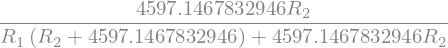

In [314]:
V_T45 = V_T.subs(R_NTC, R_charge[1])
V_T45

In [315]:
system = [Eq(V_T45, 0.45), Eq(V_T5, 0.8)]
soln = solve(system, [R_1, R_2])
soln

This produces exact values, let's bruteforce the closest real resistor values

In [318]:
# https://en.wikipedia.org/wiki/E_series_of_preferred_numbers#E24_vs._E48,_E96,_E192
def V_n(m=48):
    if m >= 48:
        sig_figs = 3
    else:
        sig_figs = 2
    n = np.arange(0, m)
    return np.around(10**(n/m), decimals=sig_figs - 1)
R_vals = V_n(48)

In [319]:
r1_idx = 0
r2_idx = 0
r1_mag = 1
r2_mag = 1
r1 = R_vals[r1_idx]*r1_mag
r2 = R_vals[r2_idx]*r2_mag

while True:
    r1 = R_vals[r1_idx]*r1_mag
    r2 = R_vals[r2_idx]*r2_mag
    v_t45 = V_T45.subs([(R_1, r1), (R_2, r2)])
    v_t5 = V_T5.subs([(R_1, r1), (R_2, r2)])
    print(f"R_1: {r1:.2f}, R_2: {r2:.2f}, v_t45: {v_t45:.4f}, v_t5: {v_t5:.4f}")
    if v_t45 > 0.45:
        r1_idx += 1
        if r1_idx >= len(R_vals):
            r1_idx = 0
            r1_mag *= 10
    elif v_t5 <= 0.8:
        r2_idx += 1
        if r2_idx >= len(R_vals):
            r2_idx = 0
            r2_mag *= 10
    else:
        break
    


R_1: 1.00, R_2: 1.00, v_t45: 0.4999, v_t5: 0.5000
R_1: 1.05, R_2: 1.00, v_t45: 0.4878, v_t5: 0.4878
R_1: 1.10, R_2: 1.00, v_t45: 0.4761, v_t5: 0.4762
R_1: 1.15, R_2: 1.00, v_t45: 0.4651, v_t5: 0.4651
R_1: 1.21, R_2: 1.00, v_t45: 0.4524, v_t5: 0.4525
R_1: 1.27, R_2: 1.00, v_t45: 0.4405, v_t5: 0.4405
R_1: 1.27, R_2: 1.05, v_t45: 0.4525, v_t5: 0.4526
R_1: 1.33, R_2: 1.05, v_t45: 0.4411, v_t5: 0.4412
R_1: 1.33, R_2: 1.10, v_t45: 0.4526, v_t5: 0.4527
R_1: 1.40, R_2: 1.10, v_t45: 0.4399, v_t5: 0.4400
R_1: 1.40, R_2: 1.15, v_t45: 0.4509, v_t5: 0.4510
R_1: 1.47, R_2: 1.15, v_t45: 0.4389, v_t5: 0.4389
R_1: 1.47, R_2: 1.21, v_t45: 0.4514, v_t5: 0.4515
R_1: 1.54, R_2: 1.21, v_t45: 0.4399, v_t5: 0.4400
R_1: 1.54, R_2: 1.27, v_t45: 0.4519, v_t5: 0.4519
R_1: 1.62, R_2: 1.27, v_t45: 0.4394, v_t5: 0.4394
R_1: 1.62, R_2: 1.33, v_t45: 0.4508, v_t5: 0.4508
R_1: 1.69, R_2: 1.33, v_t45: 0.4403, v_t5: 0.4404
R_1: 1.69, R_2: 1.40, v_t45: 0.4530, v_t5: 0.4531
R_1: 1.78, R_2: 1.40, v_t45: 0.4402, v_t5: 0.4402


In [324]:
# Print values as engineering notation
decimal.Decimal(r1).normalize().to_eng_string(), decimal.Decimal(r2).normalize().to_eng_string()

('5.62E+3', '1.27E+6')

Checking in Falstad:

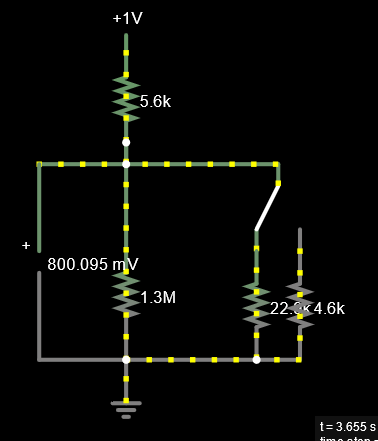
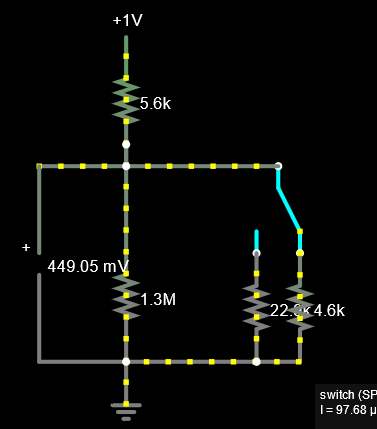

https://falstad.com/circuit/circuitjs.html?ctz=CQAgjCAMB0l3BWcMBMcUHYMGZIA4UA2ATmIxAUgpABZsKBTAWjDACgBlWsQ8DXmjxAoaVMSABmAQwA2AZwZRhbAE4hcNcISoaQxXlQSE0q9ZE0oRZzdjRKwmeJFOiqIqq-V23KPMTzQxCisxAgYKC62wqK0UbbiNAhk0GA0hBh4tsRsAO7Wwla6PGK53Lxg-PkVBqVFlUXaUGwASvn6+YSaCVQQ4jAIbADm+fEjCChKznmeo7qjU7ETozPeteZ8vO4bTQAO0T2VW6O9TXlHdnOrQA